In [1]:
# %%writefile model_2.py
import numpy as np
import pandas as pd
from pymongo import MongoClient
import pprint
import string
import re
import datetime

from my_tools import get_bill_data, process_corpus


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF

from sklearn.metrics.pairwise import linear_kernel
from sklearn.preprocessing import normalize
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix

from nltk.tokenize import word_tokenize, wordpunct_tokenize, RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet  import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.util import ngrams, skipgrams


from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB#, ComplementNB unreleased as of 12/14

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
data = get_bill_data()

------------------
Creating column 'labels'...


/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


------------------
------------------
Data is from the 110th Congress (2007) to present
------------------


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50039 entries, 24 to 12026
Data columns (total 19 columns):
_id                  50039 non-null object
bill_status          50039 non-null object
body                 50039 non-null object
committee            49574 non-null object
congress_id          50039 non-null object
cosponsors           0 non-null object
cosponsors_url       35495 non-null object
desc                 50039 non-null object
intro_date           50039 non-null datetime64[ns]
leg_id               50039 non-null object
leg_type             50039 non-null object
leg_url              50039 non-null object
num_of_cosponsors    50039 non-null object
sponsor              50036 non-null object
sponsor_district     33822 non-null object
sponsor_party        50036 non-null object
sponsor_state        50036 non-null object
bill_char_counts     50039 non-null int64
labels               50039 non-null object
dtypes: datetime64[ns](1), int64(1), object(17)
memory usage: 7.6+ MB


In [27]:
print(data['intro_date'].min(), data['intro_date'].max())

2007-01-04 00:00:00 2018-11-29 00:00:00


In [31]:
data.head()

,_id,bill_status,body,committee,congress_id,cosponsors,cosponsors_url,desc,intro_date,leg_id,leg_type,leg_url,num_of_cosponsors,sponsor,sponsor_district,sponsor_party,sponsor_state,bill_char_counts,labels
24,5c11d642cd68d16918e58ec1,Became Law,[Congressional Bills 115th Congress] [From the...,House - Financial Services,115th,None,None,To extend the National Flood Insurance Program...,2018-11-29,H R 7187,LAW,https://www.congress.gov/bill/115th-congress/h...,0,"Rep. MacArthur, Thomas",3,NJ,R,1115,1
314,5c11d643cd68d16918e58fe3,Became Law,[Congressional Bills 115th Congress] [From the...,"House - Transportation and Infrastructure, Way...",115th,None,None,"Airport and Airway Extension Act of 2018, Part II",2018-09-26,H R 6897,LAW,https://www.congress.gov/bill/115th-congress/h...,0,"Rep. Shuster, Bill",9,PA,R,3585,1
315,5c11d643cd68d16918e58fe4,Became Law,[Congressional Bills 115th Congress] [From the...,House - Judiciary | Senate - Judiciary,115th,None,https://www.congress.gov/bill/115th-congress/h...,United States Parole Commission Extension Act ...,2018-09-26,H R 6896,LAW,https://www.congress.gov/bill/115th-congress/h...,1,"Rep. Sensenbrenner, F. James, Jr.",5,WI,R,8388,1
341,5c11d643cd68d16918e58ffe,Became Law,[115th Congress Public Law 277] [From the U.S....,"House - Oversight and Government Reform, Finan...",115th,None,None,To rename the Stop Trading on Congressional Kn...,2018-09-25,H R 6870,LAW,https://www.congress.gov/bill/115th-congress/h...,0,"Rep. Tonko, Paul",20,NY,D,1209,1
453,5c11d643cd68d16918e5906e,Became Law,[Congressional Bills 115th Congress] [From the...,House - Judiciary,115th,None,https://www.congress.gov/bill/115th-congress/h...,SUCCESS Act,2018-09-10,H R 6758,LAW,https://www.congress.gov/bill/115th-congress/h...,10,"Rep. Chabot, Steve",1,OH,R,3924,1


In [33]:
data.sponsor_state.value_counts()

D     29011
R     20685
I       213
ID      127
Name: sponsor_state, dtype: int64

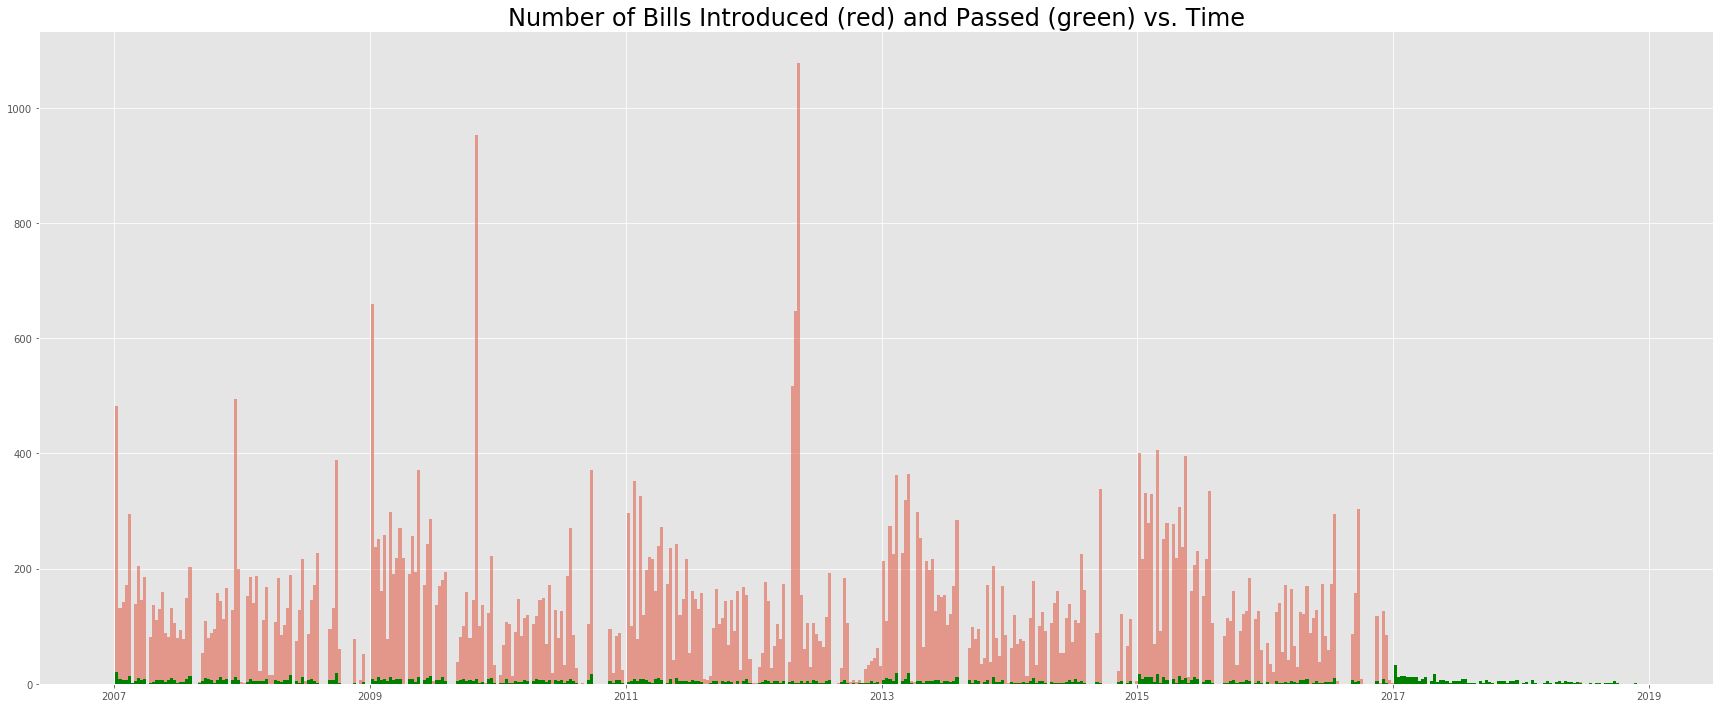

In [60]:
passed_df = data[data['labels'] == 1]

fig = plt.figure(figsize = (30, 12))
ax = fig.add_subplot(111)
ax.set_title('Number of Bills Introduced (red) and Passed (green) vs. Time', fontdict={'fontsize': 24})
ax.hist(data['intro_date'], bins = 500, alpha = .5)
ax.hist(passed_df['intro_date'], bins = 500, color = 'g')
plt.show()

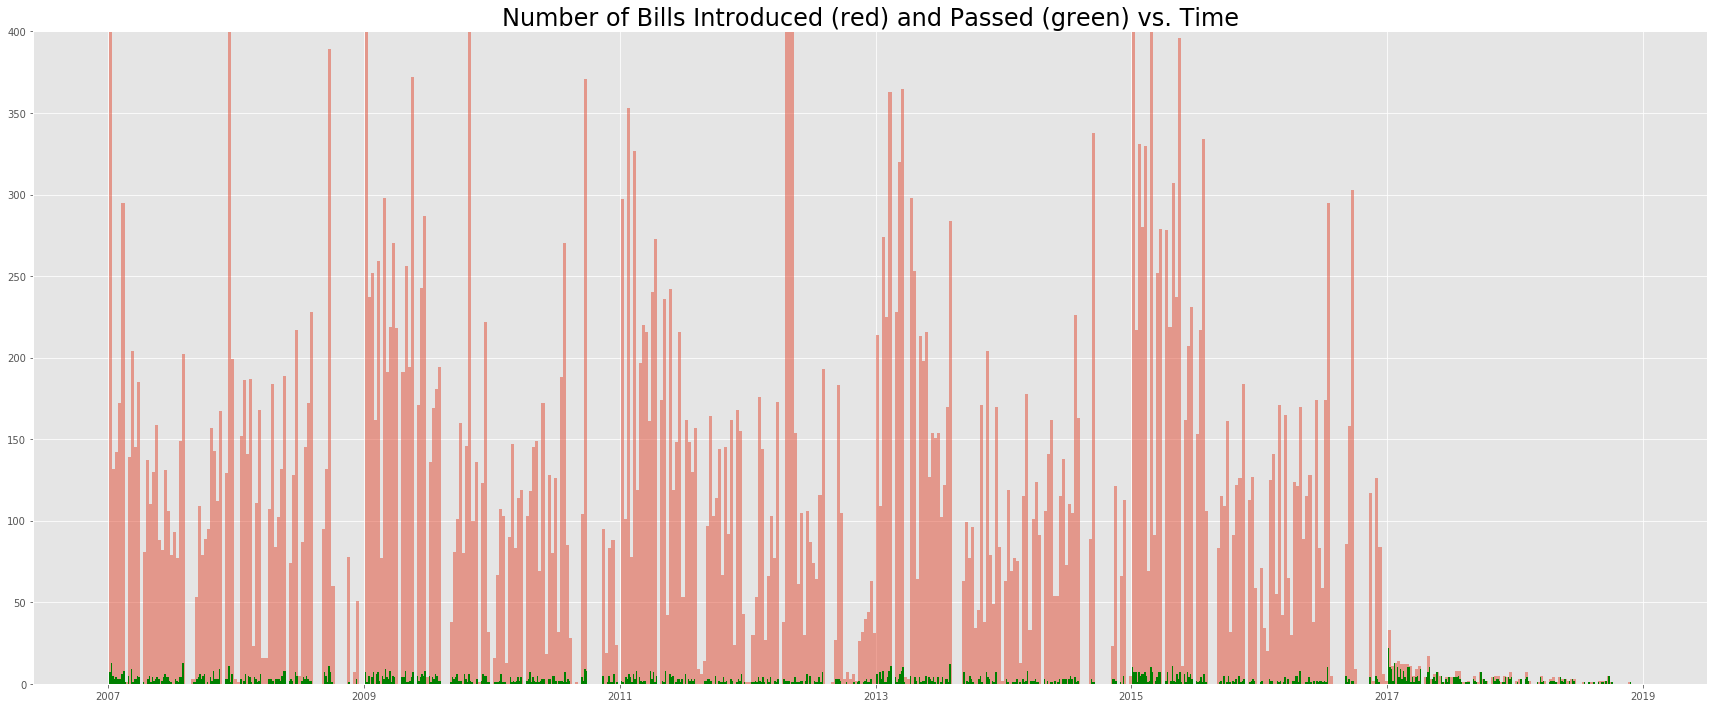

In [62]:
passed_df = data[data['labels'] == 1]

fig = plt.figure(figsize = (30, 12))
ax = fig.add_subplot(111)
ax.set_title('Number of Bills Introduced (red) and Passed (green) vs. Time', fontdict={'fontsize': 24})
ax.hist(data['intro_date'], bins = 500, alpha = .5)
ax.hist(passed_df['intro_date'], bins = 1000, color = 'g', )
ax.set_ylim(0, 400)
plt.show()